# Research Skills: Spatiotemporal Data Analyis
## Take-home Assignment - Part 2
Sharon Ong, Department of Cognitive Science and Artificial Intelligence, 
Tilburg University
Academic Year 2023-2024

Your First Name: Lorenzo

Your Last Name: Montin

Your Student ID: 2148497

In [1]:
!pip install geopandas
!pip install libpysal
!pip install spreg
!pip install esda
!pip install mapclassify

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import libpysal as ps
import geopandas as gpd
import esda as es
import spreg
from sklearn.metrics import mean_squared_error
import os
from libpysal.weights import Queen, Rook, KNN
from esda import Moran, Moran_Local
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Part 2
## Predicting the percentage of votes for a party in the 2023 Netherlands election with spatial autoregression


1. [4 points] You are provided with your own dataset of election results (XXXXX spatial:csv).*) Compute the percentage of votes the party received in each municipality. This is your targe 
variable*(b) Create a histogram plot of your target variable and the features; average income, average ho se
price and population density. Are the target variable and features normally distributed?

,GM_NAAM,GM_CODE,OuderRegioCode,GrootOuderRegioCode,total_votes,PVV,Average_House_Price,Average_Income,Population_Density,Population_Increase
0,Aa en Hunze,GM1680,K3,P22,17864,3466,284.8,26.0,93,-126
1,Aalsmeer,GM0358,K10,P27,19537,4896,409.3,29.0,1615,-13
2,Aalten,GM0197,K7,P25,17746,3513,226.1,22.4,281,-69
3,Achtkarspelen,GM0059,K2,P21,17857,6157,216.5,19.9,273,21
4,Alblasserdam,GM0482,K14,P28,12130,3031,268.4,23.7,2290,42
...,...,...,...,...,...,...,...,...,...,...
337,Zundert,GM0879,K17,P30,13873,4021,313.7,25.6,185,-74
338,Zutphen,GM0301,K7,P25,31004,5804,266.6,23.5,1181,-219
339,Zwartewaterland,GM1896,K4,P23,15003,3399,241.2,22.5,279,127
340,Zwijndrecht,GM0642,K14,P28,25143,7443,252.2,25.1,2205,-32


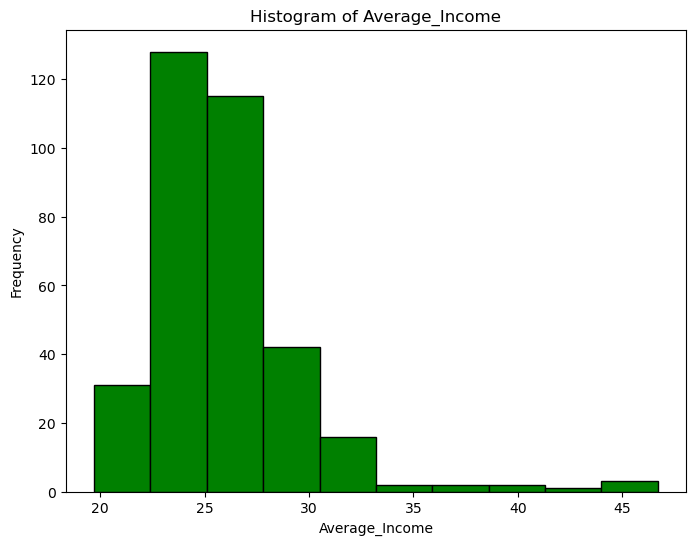

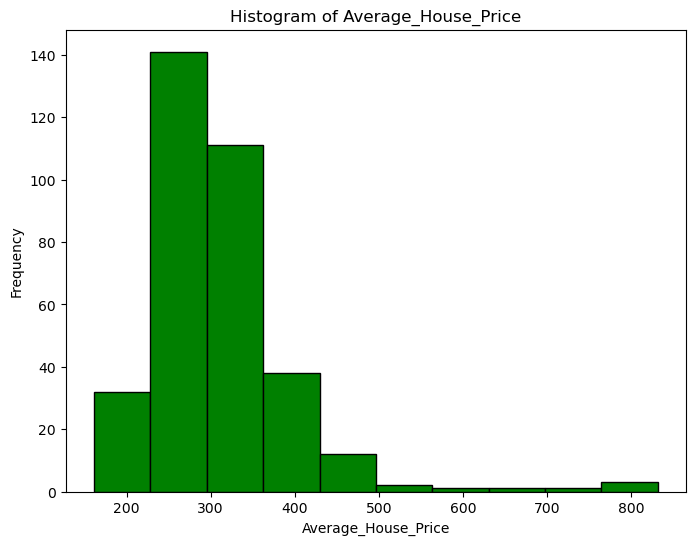

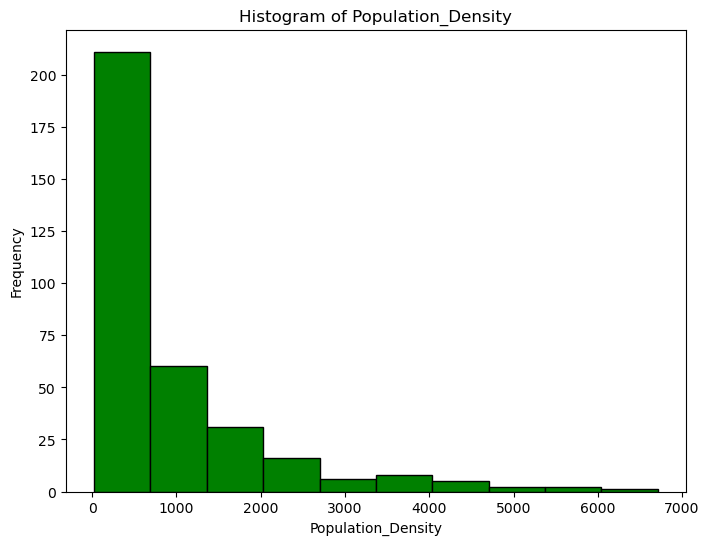

In [5]:
#
# Your code goes here
#
db = pd.read_csv("2148497_spatial.csv")
display(db)

#a)
perc_votes = round(db["PVV"]/db["total_votes"] * 100,1)
perc_votes

#b)
features = ['Average_Income', 'Average_House_Price', 'Population_Density']

for feature in features:
    plt.figure(figsize=(8,6))
    plt.hist(db[feature], bins = 10, color = "green", edgecolor = "black")
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

#all the charts are not normally distributed (positive skewed).

2. [2 points] Perform a log transformation of your target variable, population density, average income and
average house price features.

In [7]:
#
# Your code goes here
#
db["log_vote_perc"] = np.log(perc_votes +1)
db["log_pop_density"] = np.log(db["Population_Density"]+1) # adding 1 avoids the undefined case


db["log_avg_income"]  = np.log(db["Average_Income"]+1)
db["log_avg_houseprice"] = np.log(db["Average_House_Price"]+1)

print(db["log_vote_perc"])
print(db["log_pop_density"])
print(db["log_avg_income"])
print(db["log_avg_houseprice"])

0      3.015535
1      3.261935
2      3.034953
3      3.569533
4      3.258097
         ...   
337    3.401197
338    2.980619
339    3.165475
340    3.421000
341    2.839078
Name: log_vote_perc, Length: 342, dtype: float64
0      4.543295
1      7.387709
2      5.641907
3      5.613128
4      7.736744
         ...   
337    5.225747
338    7.074963
339    5.634790
340    7.698936
341    7.074963
Name: log_pop_density, Length: 342, dtype: float64
0      3.295837
1      3.401197
2      3.152736
3      3.039749
4      3.206803
         ...   
337    3.280911
338    3.198673
339    3.157000
340    3.261935
341    3.254243
Name: log_avg_income, Length: 342, dtype: float64
0      5.655292
1      6.016889
2      5.425390
3      5.382199
4      5.596197
         ...   
337    5.751620
338    5.589493
339    5.489764
340    5.534180
341    5.683920
Name: log_avg_houseprice, Length: 342, dtype: float64


3. [6 points]
* Load the shapefile of the townships of the Netherlands  and display the first five rows. Remove all the polygons (and multipolygons) representing water. Note, you do not have to display the Choropleth Map of your results, but you can if you want to.  
* Create a new column called `Pct_Votes` in the geodataframe and copy over the contents in column 
containing the percentage of votes in the dataframe from Question 1. Drop all the rows with missin 
values. (Hint: you can use the 'join' or 'merge' function in pandas)
(c) Display a Choropleth Map of the townships, with colors assigned `Pct_Votes` (`columns=Pct_Votes`). 
Use a quantiles scheme with 5 quantiles.P
ct

,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,P_GEBBL_EU,P_GEBBL_NE,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,layer,path,geometry
0,GM0034,Almere,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0034,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((150087.299 479382.379, 150000...."
1,GM0050,Zeewolde,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0050,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((155047.32 474836.246, 155049.0..."
2,GM0060,Ameland,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0060,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((196000 608000, 195250 607500, 193000..."
3,GM0072,Harlingen,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0072,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((158000 581000, 158331.38 58046..."
4,GM0088,Schiermonnikoog,JA,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2023GM0088,2023,2023 — gemeente_2023_v1water,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((219000 616201.447, 219000 616000, 21..."


Text(0.5, 1.0, 'Map showing water regions')

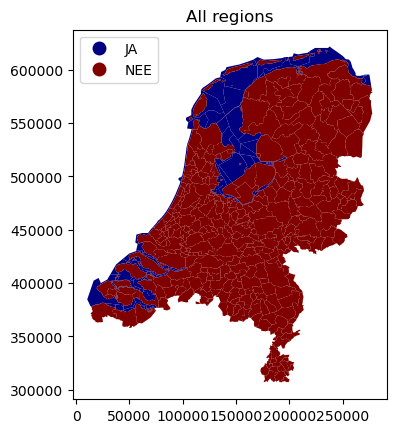

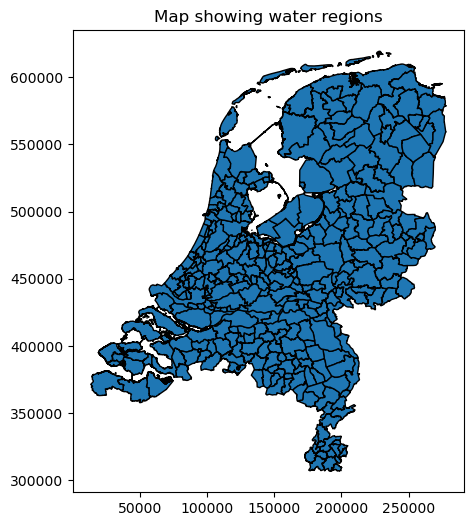

In [9]:
#
# You code goes here 
#
#a
votes = gpd.read_file('wijkbuurtkaart_2023_v1/gemeenten_2023_v1.shp')
display(votes.head())
votes.plot(column='H2O', cmap='jet', categorical=True, legend=True, legend_kwds={'loc': 'upper left'})
plt.title("All regions")

no_water = votes.loc[votes.H2O == "NEE"] #loc select rows/col
no_water.plot(figsize=(6, 6), edgecolor='black')
plt.title("Map showing water regions")

In [11]:
#b 
new_vote = no_water.merge(db[['GM_CODE', 'PVV', "total_votes", "Average_Income", "Average_House_Price","Population_Density"]], on='GM_CODE', how='left') #merge combines rows based on matching values in specified columns from two DataFrame
#how='left' ensures all spatial areas are preserved, even if missing vote data.
new_vote['Pct_Votes'] = perc_votes
new_vote = new_vote.dropna(subset=['Pct_Votes']) #removing unmatched areas 

new_vote.head()

,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,JAAR,layer,path,geometry,PVV,total_votes,Average_Income,Average_House_Price,Population_Density,Pct_Votes
0,GM0014,Groningen,NEE,3427.0,1.0,1284.0,238147.0,118198.0,119949.0,12.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((245229.7 592570.87, 245250.71 592551...",19346.0,146649.0,23.3,258.9,1266.0,19.4
1,GM0034,Almere,NEE,1629.0,2.0,1725.0,222825.0,110589.0,112236.0,18.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((142993.709 482642.714, 142993....",27773.0,104685.0,24.7,294.3,1686.0,25.1
2,GM0037,Stadskanaal,NEE,840.0,4.0,273.0,32135.0,15844.0,16291.0,14.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((263763.866 566430.392, 263944.283 56...",6323.0,19335.0,20.5,185.5,271.0,19.8
3,GM0047,Veendam,NEE,1013.0,3.0,364.0,27616.0,13863.0,13753.0,14.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"POLYGON ((256504.591 572265.478, 256541.115 57...",5201.0,16441.0,21.6,187.5,362.0,34.5
4,GM0050,Zeewolde,NEE,842.0,4.0,96.0,23692.0,12003.0,11689.0,17.0,...,2023,2023 — gemeente_2023_v1zw,\\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...,"MULTIPOLYGON (((165488.532 478414.424, 165480....",3640.0,14376.0,25.7,275.7,94.0,25.0


Text(0.5, 1.0, 'Choropleth Map of Townships by Percentage of Votes')

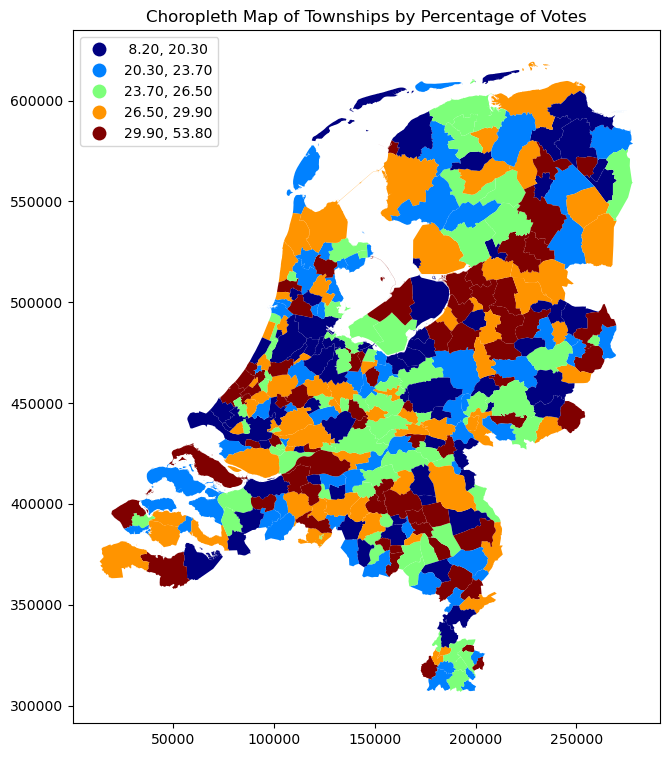

In [13]:
#c
new_vote.plot(figsize=(9, 9), column='Pct_Votes', scheme='QUANTILES', k=5, cmap='jet', legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Choropleth Map of Townships by Percentage of Votes')


4. [6 points] Using contiguity based weighting schemes (rook and queen) and KNN based weighing schemes, 
compute and compare the global autocorrelation (Global Moran's I) of the log transformation of th 
Pct Votes. Try at least 3 dierent K number of neighbours.

In [15]:
#
# Your code goes here 
#
new_vote['log_Pct_Votes'] = np.log(new_vote['Pct_Votes'] + 1)  # Adding 1 to avoid log(0) issues

queen_weights = Queen.from_dataframe(new_vote) #Queen connects any polygon that shares a vertex or edge.
rook_weights = Rook.from_dataframe(new_vote) #Rook connects only those sharing an edge.

queen_weights.transform = 'r' #'r' standardizes weights so they sum to 1 per row.
rook_weights.transform = 'r'

knn_5 = KNN.from_dataframe(new_vote, k=5)
knn_10 = KNN.from_dataframe(new_vote, k=10)
knn_15 = KNN.from_dataframe(new_vote, k=15)

knn_5.transform = 'r'
knn_10.transform = 'r'
knn_15.transform = 'r'

moran_queen = Moran(new_vote['log_Pct_Votes'], queen_weights)
moran_rook = Moran(new_vote['log_Pct_Votes'], rook_weights)

moran_knn_5 = Moran(new_vote['log_Pct_Votes'], knn_5)
moran_knn_10 = Moran(new_vote['log_Pct_Votes'], knn_10)
moran_knn_15 = Moran(new_vote['log_Pct_Votes'], knn_15)

#Moran’s I values:
#Close to +1: high spatial autocorrelation (similar values cluster together).
#Around 0: random spatial pattern.
#Close to –1: strong spatial dispersion (opposites attract).

print(f"Moran's I for Queen Contiguity: {moran_queen.I}")
print(f"Moran's I for Rook Contiguity: {moran_rook.I}")
print(f"Moran's I for KNN (k=5): {moran_knn_5.I}")
print(f"Moran's I for KNN (k=10): {moran_knn_10.I}")
print(f"Moran's I for KNN (k=15): {moran_knn_15.I}")

C:\Users\monti\AppData\Local\Temp\ipykernel_23420\645039533.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen_weights = Queen.from_dataframe(new_vote) #Queen connects any polygon that shares a vertex or edge.
C:\Users\monti\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 6.
  W.__init__(self, neighbors, ids=ids, **kw)
C:\Users\monti\AppData\Local\Temp\ipykernel_23420\645039533.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  rook_weights = Rook.from_dataframe(new_vote) #Rook connects only those sharing an edge.
C:\Users\monti\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix i

('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
Moran's I for Queen Contiguity: -0.016180121140573427
Moran's I for Rook Contiguity: -0.01095261947716191
Moran's I for KNN (k=5): -0.04639651538833014
Moran's I for KNN (k=10): -0.02985936445955508
Moran's I for KNN (k=15): -0.028284890669472644


5. [8 points] Compute the local autocorrelation. Choose the weighting scheme and parameters for which 
gave you the highest correlation inQ4.. Identify the 'hotspots' and 'coldspots' by displaying the hotspot 
as these townships with ffierent colors in a scatter plot or Choropleth map.

Points breakdown: 2 points for computing local autocorrelation ad2 3 points for displaying the hotspots for Average Income. 2 points for computing local autocorrelation ad2 3 points for displaying the hotspots for the log transformation of Average Income.

C:\Users\monti\anaconda3\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


(342.3655000925064, 291249.12450015545, 291226.9254649401, 634850.9212352515)

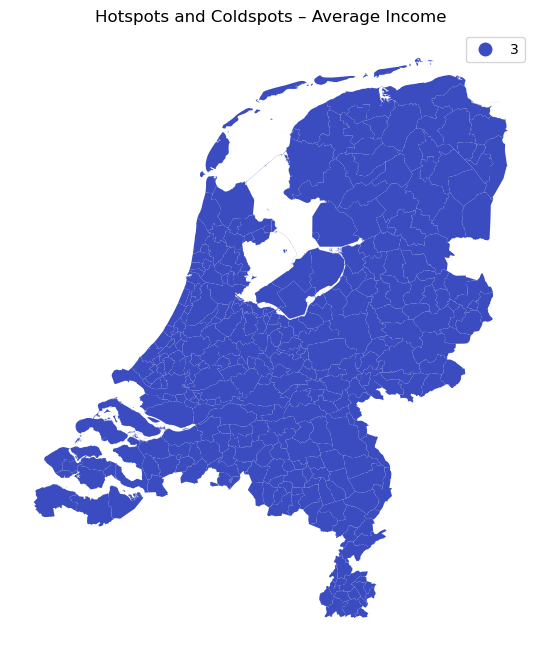

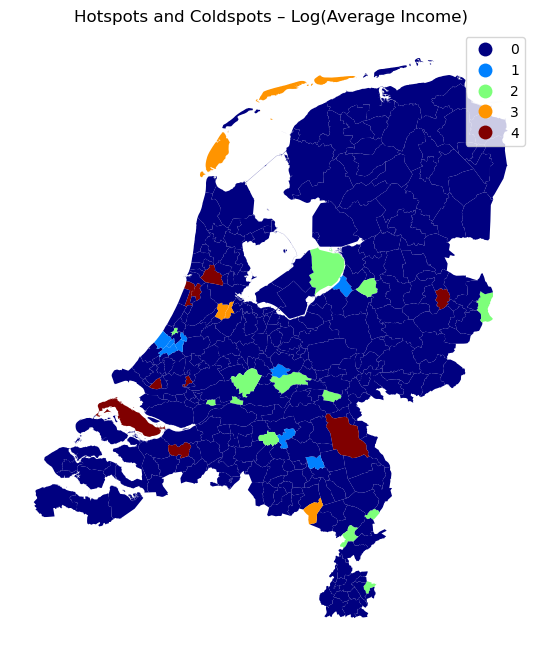

In [17]:
avg_income_autocor = Moran_Local(new_vote["Average_Income"], rook_weights)
log_income_autocorr = Moran_Local(new_vote['log_Pct_Votes'], rook_weights)

new_vote['income_cluster'] = avg_income_autocor.q  #q is the cluster type
new_vote['income_sig'] = avg_income_autocor.p_sim < 0.05 #p_sim gives a p-value from a randomization test to check statistical significance.
#p < 0.05 so we only keep clusters that are very likely to be real
new_vote['log_income_cluster'] = log_income_autocorr.q
new_vote['log_income_sig'] = log_income_autocorr.p_sim < 0.05


new_vote['cluster_plot'] = new_vote.apply(lambda row: row['income_cluster'] if row['income_sig'] else 0, axis=1)
#If the cluster is statistically significant, we keep its value (1–4).
#If it’s not significant, we label it as 0 (so it doesn’t get plotted as a meaningful cluster).
#row['log_income_sig'] is a boolean, if exists is stored otherwise gets 0
fig, ax = plt.subplots(1, figsize=(12, 8))
new_vote.plot(column='cluster_plot', cmap='coolwarm', legend=True, categorical=True, ax=ax)
ax.set_title("Hotspots and Coldspots – Average Income")
ax.axis('off')


new_vote['log_cluster_plot'] = new_vote.apply(lambda row: row['log_income_cluster'] if row['log_income_sig'] else 0, axis=1)

fig, ax = plt.subplots(1, figsize=(12, 8))
new_vote.plot(column='log_cluster_plot', cmap='jet', legend=True, categorical=True, ax=ax)
ax.set_title("Hotspots and Coldspots – Log(Average Income)")
ax.axis('off')


6. [10 points] YYour goal is to estimate the Pct Votes (log values) per municipality based on the explanatory 
variables (the average house price and population density) and the spatially lagged Pct Votes (endog
nous regressor). Please use the log form of the variables from Question 2 for this question. Please u e
t'e \sp' g" package for this task. Chose one weighing scheme a* Fit a linear regression model, where your target variable is the Pct Votes (in log form) and your
features (exploratory variables) are population density, average income and average house price
features (in log form)* b) Using the GM Lag, run a spatial autoregression model with the features in (a

(e) Compute the mean square error for the regressors in (a), (d). Which regressor model resulted in the lowest mean square eoints]

In [19]:
#
# Your code goes here 
#

#a
X = db[["log_pop_density", "log_avg_income" , "log_avg_houseprice"]]
y = db["log_vote_perc"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

#b
merged = votes.merge(db, on="GM_NAAM", how="inner") #AI helped after multiple errors
#Merges the votes and db on the municipality name (GM_NAAM) to align spatial info with your data.

variable_names = ['log_pop_density', 'log_avg_income', 'log_avg_houseprice']
X = merged[variable_names].values
y = merged["log_vote_perc"].values

w = ps.weights.KNN.from_dataframe(merged, k=6) #Create a spatial weight matrix using 6-nearest neighbors(KNN k=6).
w.transform = 'r'  # row-standardize weights

gm_model = spreg.GM_Lag(y, X, w=w, name_y='log_vote_perc', name_x=variable_names)#spatial lag model, accounts for autocorrelation ignore in linear regression
y_pred_gm = gm_model.predy
mse_gm = mean_squared_error(y, y_pred_gm)

print(gm_model.summary)

print("Mean Squared Error linear regression:", mse)
print("Mean Squared Error GM_lag:", mse_gm)



REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_vote_perc                Number of Observations:         412
Mean dependent var  :      3.2326                Number of Variables   :           5
S.D. dependent var  :      0.2569                Degrees of Freedom    :         407
Pseudo R-squared    :      0.2448
Spatial Pseudo R-squared:  0.3082

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         6.68159         0.78360         8.52683         0.00000
     log_pop_density         0.00977         0.01071         0.91190         0.36182
      log_avg_income         0.31943     

7. [8 points] Your goal is to predict the Pct Votes (log values) per municipality based on the features (the 
average house price and population density) and the spatial lag of Pct Votes. You can use the sklear 
package. Please use the log form of the variables from Question 2 for this questio
* Split your data (group-wise) into train and test sets with an appropriate test size. You can use the 
province ID (GrootOuderRegioCode) in your le as the groupID.*b) Train a three regressors of your choice with a 5-fold cross validation and grid search* c) Using the best hyperparameter found from grid search on the training set, evaluate the m an
square error on two dierent regression algorithms.n.

In [21]:
#
# Your code goes here 
#
#a

province_neighbors = {}
for province in db["GrootOuderRegioCode"].unique():
    indices = db[db["GrootOuderRegioCode"] == province].index.tolist()#ai helped me to get here
    #For each province, you find all rows (municipalities) that belong to that province via their index 
    for i in indices:
        province_neighbors[i] = [j for j in indices if j != i]
    #dict where keys are  municipality index, and the value is a list of neighboring municipality indices
w = ps.weights.W(province_neighbors) #creates a PySAL spatial weights object from the neighbors dictionary.
w.transform = 'r' 

db["log_vote_perc"] = ps.weights.lag_spatial(w,db["log_vote_perc"]) # use rooks weights
X = db[["log_pop_density", "log_avg_houseprice"]]  # exclude spatial lag for now
y = db["log_vote_perc"]
groups = db["GrootOuderRegioCode"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #creates train-test splits such that no provinces appear in both train and test sets. 
train_idx, test_idx = next(gss.split(X, y, groups=groups))
#Since you only want one split,  next() gets the first (and only) split from that generator.

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] #ai helped me to define this
# integer-location based indexing, allows to select rows and/or columns by their integer position

C:\Users\monti\AppData\Local\Temp\ipykernel_23420\4276199886.py:13: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  w = ps.weights.W(province_neighbors) #creates a PySAL spatial weights object from the neighbors dictionary.


In [23]:
#b,c
models = {
    "LinearRegression": {"model": Pipeline([("scaler", StandardScaler()), ("reg", LinearRegression())]),"params": {}},
    "Ridge": {"model": Pipeline([("scaler", StandardScaler()), ("reg", Ridge())]), "params": {"reg__alpha": [0.01, 0.1, 1, 10, 100]}},
    "RandomForest": {"model": RandomForestRegressor(random_state=42), "params": {"n_estimators": [50, 100], "max_depth": [None, 5, 10]}}}

best_models = {}

for name, m in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(estimator=m["model"], param_grid=m["params"], cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    grid.fit(X, y)
    
    best_models[name] = grid
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best MSE (neg): {grid.best_score_:.3f}\n")

Training LinearRegression...
Best params for LinearRegression: {}
Best MSE (neg): -0.015

Training Ridge...
Best params for Ridge: {'reg__alpha': 10}
Best MSE (neg): -0.015

Training RandomForest...
Best params for RandomForest: {'max_depth': 5, 'n_estimators': 100}
Best MSE (neg): -0.016



8. [6 points] With your best regression model from Question 7, perform a nested cross validation to predict 
the votes of each municipality in the dataset. The group-wise nested cross-validation involves two loop 
of cross-validation*
 Inner Loop: This is where hyperparameter tuning happens. The dataset is split into training  nd
validation sets, and the model is optimized using the validation set (which you have perfo med
ab*ve)
 Outer Loop: Whffre dierent group-wise splits of train and test sets are created. (You can use the
StratiedGroupKFold or GroupKFold fun

tion).
At each fold, compute the prediction error of each municipality in the test set. Display Choropl th Maps
of the townships, with colors assthe igned by prediction errors. Use a quantiles scheme with 5 quantiles.

In [35]:
#
# Your code goes here 
#

